In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from itertools import combinations
import statistics
import math

In [3]:
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/Asian_site_ard2.csv')
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_NSR.csv')
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_SR.csv')
dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/dataframe-tve.csv')
dataframe = dataframe[dataframe["Coincidence"] < 1].reset_index()
dataframe = dataframe.drop(columns=["index"])
dataframe = dataframe[dataframe['Salinity']>20]

In [4]:
tempdf = pd.DataFrame()
tempdf['Tmean'] = dataframe[['pH','Salinity','Ammonia']].mean()
tempdf['Tstd'] = dataframe[['pH','Salinity','Ammonia']].std()
for date in dataframe['Date of Image'].unique():
  df = dataframe.loc[dataframe['Date of Image'] == date]
  tempdf[f'{date}_mean'] = df[['pH','Salinity','Ammonia']].mean()
  tempdf[f'{date}_std'] = df[['pH','Salinity','Ammonia']].std()

In [5]:
tempdf

,Tmean,Tstd,2022-07-14_mean,2022-07-14_std,2022-09-12_mean,2022-09-12_std,2023-04-25_mean,2023-04-25_std,2023-05-30_mean,2023-05-30_std,2023-07-09_mean,2023-07-09_std
pH,8.205357,0.361522,8.600,0.106904,8.43750,0.170783,7.6250,0.150000,7.900000,0.264575,8.166667,0.276887
Salinity,33.678571,6.390638,37.875,1.807722,35.56250,3.898183,26.0000,3.366502,24.923077,1.754116,39.066667,2.051712
Ammonia,0.043750,0.032784,0.000,0.000000,0.02625,0.015438,0.0275,0.009574,0.074615,0.025038,0.063333,0.024398


In [6]:
dataframe.head()

,PondID,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,...,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,TUPILIPALEM_A2,8.4,35,30,120,150,6300,388,1296,0.0,...,612,1253,1154,919,1025,1059,1171,920,1188,165
1,TUPILIPALEM_A3,8.7,38,40,120,160,6800,472,1471,0.0,...,484,1179,1065,794,854,918,1042,737,993,131
2,TUPILIPALEM_A4,8.7,39,40,110,150,6960,482,1488,0.0,...,432,1114,969,708,779,727,825,641,897,170
3,TUPILIPALEM_A5,8.7,40,40,120,160,7100,488,1491,0.0,...,524,1127,950,798,734,844,963,614,952,157
4,TUPILIPALEM_B2,8.6,36,50,110,160,6200,378,1302,0.0,...,710,1236,1162,1108,1114,1217,1268,828,1254,169


In [7]:
print("pH Minimum Value:", dataframe["pH"].min())
print("Salinity Minimum Value:", dataframe["Salinity"].min())

pH Minimum Value: 7.5
Salinity Minimum Value: 22


In [8]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
wavelengths = [442.7,	492.4,559.8,664.6,704.1,740.5,782.8,832.8,864.7,945.1,1373.5,1613.7,2202.4]
parameters = ["pH", "Salinity", "Ammonia"]

In [9]:
dataframe[["pH", "Salinity", "Ammonia"]].std()/np.array([8.5, 45, 0.5])

pH          0.042532
Salinity    0.142014
Ammonia     0.065567
dtype: float64

## WQI calculation

In [10]:
# def derivative(dataframe):
#     banddata = dataframe[bands]
#     for wave,band in (wavelengths,bands):



#     return None

def calculateWQI(parameters):
    # order of parameters ph salinity ammonia
    expdf = pd.DataFrame()
    permissibleValuesParameters = np.array([8.5, 45, 0.5])
    summ = 0
    sumWn = 0
    weights =   np.array([0.2,0.6,0.2]) # np.array(parameters.std()/permissibleValuesParameters)
    weightsnormalized = weights/sum(weights)
    for column, sn, Wn in zip(parameters.columns, permissibleValuesParameters, weightsnormalized):
        vn = parameters[column]
        if column=="pH":
            vid = 7.5
        elif column=="Salinity":
            vid = 15
        else:
            vid = 0.0
        qn = 100*(vn - vid)/(sn-vid)

        summ = summ + (qn*Wn)
        sumWn = sumWn + Wn
    expdf['summ'] = summ
    expdf['qn'] = qn
    WQI = summ/sumWn
    return WQI,expdf

def bandmath(bandMatrix,WQI):
  df = pd.DataFrame()
  cc = list(combinations(bandMatrix.columns,2))
  print(cc)
  for combination in cc:
    a = combination[0]
    b = combination[1]
    diffIndex = bandMatrix[a] - bandMatrix[b]
    normlizedIndex = (bandMatrix[a] - bandMatrix[b])/bandMatrix[a] + bandMatrix[b]
    ratioIndex = bandMatrix[a] / bandMatrix[b]
    df[f'diff_{a}_{b}'] = diffIndex
    df[f'norm_{a}_{b}'] = normlizedIndex
    df[f'ratio_{a}_{b}'] = ratioIndex
  df['WQI_cal'] = WQI
  return  df

def pca(data):
  pca = PCA(n_components=3)
  pca.fit(data)
  pca_data =  pca.transform(data)
  return  pca_data

def harmonizedWQIcalculation(GT):
  min = np.array([7.5,9,0])
  max = np.array([8.7,43,0.12])
  permissibleWP = np.array([8.5,45,0.5])
  weights =  np.array(GT.std()/permissibleWP)
  weights_norm = weights/sum(weights)
  numP = len(weights_norm)
  rr = max - min
  allWQI  = np.array([])
  n = len(GT)
  for val in GT.values:
    i = 0
    Tsumm = np.array([])
    for para in val:
        qi =None
        summ = 0
        if  min[i] <= para  <= 0.10*rr[i]:
          qi = 5
        if  0.1*min[i] <= para  <= 0.20*rr[i]:
          qi = 15
        if  0.20*rr[i] <= para  <= 0.30*rr[i]:
          qi = 25
        if  0.30*rr[i] <= para  <= 0.40*rr[i]:
          qi = 35
        if  0.40*rr[i] <= para  <= 0.50*rr[i]:
          qi = 45
        if  0.50*rr[i] <= para  <= 0.60*rr[i]:
          qi = 55
        if  0.60*rr[i] <= para  <= 0.70*rr[i]:
          qi = 65
        if  0.70*rr[i] <= para  <= 0.80*rr[i]:
          qi = 75
        if  0.80*rr[i] <= para  <= 0.90*rr[i]:
          qi = 85
        if  0.90*rr[i] <= para  <= max[i]:
          qi = 95
        # print(qi,para,rr[i])
        summ += 1/qi
        i+=1
        Tsumm = np.append(Tsumm,summ)
    WQI = sum([(weights_norm[i])*math.sqrt(i+1/Tsumm[i]**2) for i in range(numP)])/numP
    allWQI = np.append(allWQI,WQI)

  return allWQI


(array([ 3.,  4.,  4.,  5.,  2.,  1.,  6.,  9., 11., 11.]),
 array([15.6 , 21.52, 27.44, 33.36, 39.28, 45.2 , 51.12, 57.04, 62.96,
        68.88, 74.8 ]),
 <BarContainer object of 10 artists>)

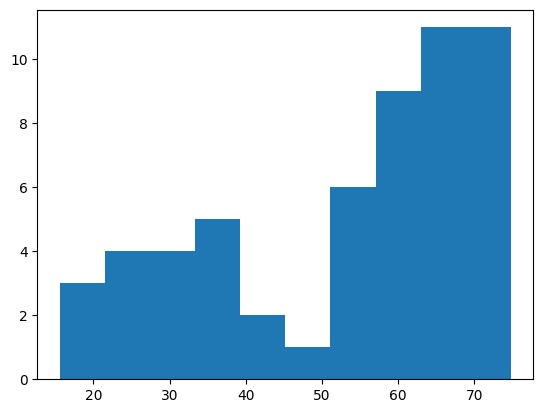

In [11]:
wqi,expdf= calculateWQI(dataframe[parameters])
## plotting distribution of wqi
plt.hist(wqi)

In [12]:

## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(wqi))
print("Standard Deviation WQI", statistics.stdev(wqi))

Mean WQI 53.21428571428571
Standard Deviation WQI 17.430750555700833


## Model for the WQI to indiviual parameter

In [13]:


def CM(actual, predicted,x,y):
  fig = plt.figure()
  plt.scatter(actual, predicted)
  # vs  = pd.DataFrame(validationdataframe)
  # print(vs)
  plt.scatter(x,y)
  plt.show()

def Presults(y_test, prediction):
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  # return model.coef_,model.intercept_

def LRegression(dataframe,index,name,WQI_val,GT_val,):
  # CM(dataframe[name],dataframe[index])
  # for i ,j in zip(dataframe[index],WQI_val):
  #   print(i,j)
  # dataframe[index] = scaler.inverse_transform(np.array(dataframe[index]).reshape(-1, 1))
  # WQI_val = scaler.inverse_transform(np.array(WQI_val).reshape(-1, 1))
  # for i ,j in zip(dataframe[index],WQI_val):
  #   print(i,j)

  # validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
  # traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

  # CM(dataframe[name],dataframe[index],validationdataframe[name],validationdataframe[index])

  # xTrain = np.array((traindataframe[index])).reshape(-1, 1)
  # yTrain = traindataframe[name]
  # xTest = np.array((validationdataframe[index])).reshape(-1, 1)
  # yTest = validationdataframe[name]

  xTrain, xTest, yTrain, yTest = train_test_split(dataframe[index], dataframe[name], test_size=0.33, random_state=42)
  xTrain = np.array(xTrain).reshape(-1, 1)
  yTrain = np.array(yTrain).reshape(-1, 1)
  xTest = np.array(xTest).reshape(-1, 1)
  yTest = np.array(yTest).reshape(-1, 1)

  model = LinearRegression().fit(xTrain, yTrain)
  # model = SVR(kernel='rbf', C=1.0, epsilon=1e-4).fit(xTrain, yTrain)
  if name == 'Ammonia':
  #   # print('hi')
      model = RandomForestRegressor(max_depth=2, random_state=0).fit(xTrain, yTrain)
  prediction = model.predict(xTest)
  prediction_val = model.predict(WQI_val)
  for x,y in zip(yTest,prediction):
    print(x,'-',y)
  plt.figure(figsize=(5,5))
  plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red",label = 'Actual')
  plt.scatter(np.arange(1, len(yTest)+1), prediction, color="blue",label = 'Predicted')
  # plt.scatter(yTest,prediction)
  # lims = [max(max(yTest),max(prediction)),min(min(yTest),min(prediction))]

  # plt.xlim([0.95*lims[1],1.05*lims[0]])
  # plt.ylim([0.95*lims[1],1.05*lims[0]])
  plt.legend()
  plt.show()

  Presults(yTest, prediction)
  print(f"validation results on {name}")
  Presults(GT_val,prediction_val)
  for x,y in zip(GT_val,prediction_val):
    print(x,'-',y)
  print(f"---------------------------------------")


#to predict the parameters from WQI



def WQIandParameters(dataframe,index,predictedWQI,gtforRE):
  print('-----For WQI with pH Regression relation-----')
  LRegression(dataframe,index,'pH',predictedWQI,gtforRE['pH'])
  print('-----For WQI with Salinity  Regression relation-----')
  LRegression(dataframe,index,'Salinity',predictedWQI,gtforRE['Salinity'])
  print('-----For WQI with Ammonia SVR relation-----')
  LRegression(dataframe,index,'Ammonia',predictedWQI,gtforRE['Ammonia'])
  return None



In [14]:
# sns.pairplot(dataframe)
dataframe["WQI"] = wqi

## Model for Band to WQI index

In [15]:

def scaling(Banddata):
    scaler = StandardScaler()
    scaler.fit(Banddata)
    dataframe = scaler.transform(Banddata)
    return dataframe

def pca(dataframe):
  pca = PCA(n_components=3)
  pca.fit(dataframe)
  pca_df =  pca.transform(dataframe)
  return pca_df

# def weakmodel(xTrain, yTrain,xTest):
#       models = [
#         RandomForestRegressor(max_depth=3, random_state=0),
#         xgb.XGBRegressor(),
#         SVR(kernel='rbf', C=1.0, epsilon=1e-3)]

#       preds = []
#       for i, m in enumerate(models):
#           m.fit(xTrain, yTrain)
#           preds.append(m.predict(xTest))

#       weights = [0.33, 0.33,0.33]
#       preds = np.array(preds)
#       print
#       preds= np.sum(preds, axis = 0)/3
#       return preds

### model to predict WQI using bands as input
def predictWQI(dataframe,pred,valpredict):
    # validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

    traindataframe, validationdataframe = train_test_split(dataframe, test_size=0.3, random_state=42)
    traindataframe.to_csv('WQIModelTrain.csv')
    validationdataframe.to_csv('WQIModelTest.csv')

    validationdataframe2 = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    traindataframe2 = scaling(dataframe[dataframe["Date of Image"]=="2023-07-09"][bands])
    # k =  10
    # k_fold = KFold(n_splits = k,shuffle=True )


    gtforRE = (validationdataframe[parameters])
    gtforRE2 = (validationdataframe2[parameters])

    xTrain = (scaling(traindataframe[bands]))
    yTrain = traindataframe[pred]
    xTest = (scaling(validationdataframe[bands]))
    yTest = validationdataframe[pred]

    model = SVR(kernel='rbf', C=2.0, epsilon=1e-4)
    # model = RandomForestRegressor(max_depth=3, random_state=0)
    # model = MLPRegressor(random_state=1, max_iter=100000)

    model.fit(xTrain, yTrain)

    # score = cross_val_score(model, dataframe[bands], dataframe[pred], cv = k_fold)
    # print(sum(score) / len(score))
    # print(score)
    # prediction =  weakmodel(xTrain,yTrain,xTest)
    prediction = model.predict(xTest)
    # prediction = preds
    # print(prediction,yTest)
    predition2  = model.predict(traindataframe2)
    prediction3 = model.predict(scaling(valpredict[bands]))

    print("MAE", mean_absolute_error(yTest, prediction))
    print("MSE", mean_squared_error(yTest, prediction))
    print("RMSE", mean_squared_error(yTest, prediction, squared=False))
    print("MAPE", mean_absolute_percentage_error(yTest, prediction))
    print("R2 Score", r2_score(yTest, prediction))
    plt.figure(figsize=(25,10))
    plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red")
    plt.plot(np.arange(1, len(yTest)+1), prediction, color="blue")
    return prediction,predition2,prediction3,gtforRE,gtforRE2

In [16]:
(dataframe).corrwith(dataframe['WQI'],method = 'spearman')

<ipython-input-16-aa275eb3de0b>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['WQI'],method = 'spearman')
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


pH             0.753315
Salinity       0.902928
Carbonate      0.691606
BiCarbonate   -0.377968
Alkalinity     0.103337
Hardness       0.280152
Calcium       -0.502205
Magnesium      0.856039
Ammonia       -0.289950
Coincidence         NaN
B1            -0.716810
B10           -0.449607
B11           -0.610715
B12           -0.588089
B2            -0.735281
B3            -0.746779
B4            -0.745920
B5            -0.738990
B6            -0.698106
B7            -0.688148
B8            -0.711749
B8A           -0.684337
B9            -0.614894
WQI            1.000000
dtype: float64

(array([ 3.,  4.,  4.,  5.,  2.,  1.,  6.,  9., 11., 11.]),
 array([15.6 , 21.52, 27.44, 33.36, 39.28, 45.2 , 51.12, 57.04, 62.96,
        68.88, 74.8 ]),
 <BarContainer object of 10 artists>)

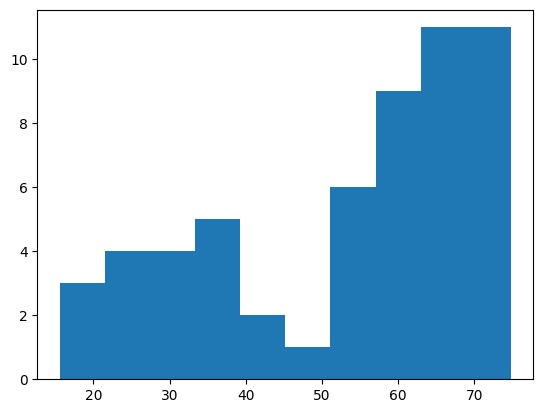

In [17]:

plt.hist(dataframe['WQI'])

In [18]:


print(dataframe['WQI'].head())
scaler2 = MinMaxScaler()
# scaler2 = StandardScaler()
dataframe['WQI'] = scaler2.fit_transform(dataframe[['WQI']]).flatten()
print(dataframe['WQI'].head())

0    58.0
1    70.0
2    72.0
3    74.0
4    64.0
Name: WQI, dtype: float64
0    0.716216
1    0.918919
2    0.952703
3    0.986486
4    0.817568
Name: WQI, dtype: float64


In [19]:
validationset = pd.read_csv('/content/drive/MyDrive/WQA_data/testset.csv')

validationset['pH'] = [8.0,8.1,8.1,7.8,7.5]
validationset['Salinity'] = [30,30,25,20,22]
validationset['Ammonia'] = [0.07,0.03,0.04,0.04,0.08]
validationset['Carbonate'] = [0,10,10,0,0]
validationset['BiCarbonate'] = [150,200,250,100,110]
validationset['Alkalinity'] = [150,200,250,100,110]
validationset['Hardness'] = [6800,6960,6500,7100,7500]
validationset['Calcium'] = [684,688,644,1080,1102]
validationset['Magnesium'] = [1232,1262,1126,1069,1121]
validationset

,B1,B10,B11,B12,B2,B3,B4,B5,B6,B7,...,PondID,pH,Salinity,Ammonia,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium
0,1209,96,691,437,954,1030,735,967,884,932,...,BR_P1,8.0,30,0.07,0,150,150,6800,684,1232
1,1212,81,1029,623,933,834,590,884,1423,1755,...,BR_P2,8.1,30,0.03,10,200,200,6960,688,1262
2,1198,102,921,532,1000,988,715,995,1026,1260,...,BR_P3,8.1,25,0.04,10,250,250,6500,644,1126
3,2110,360,1342,958,1730,1556,1417,1502,1862,2148,...,M_P1,7.8,20,0.04,0,100,100,7100,1080,1069
4,2123,358,1340,976,1746,1605,1416,1492,1850,2141,...,M_P2,7.5,22,0.08,0,110,110,7500,1102,1121


MAE 0.1157440218319695
MSE 0.02074588746431947
RMSE 0.144034327381772
MAPE 0.3808109734506127
R2 Score 0.7659359608101399


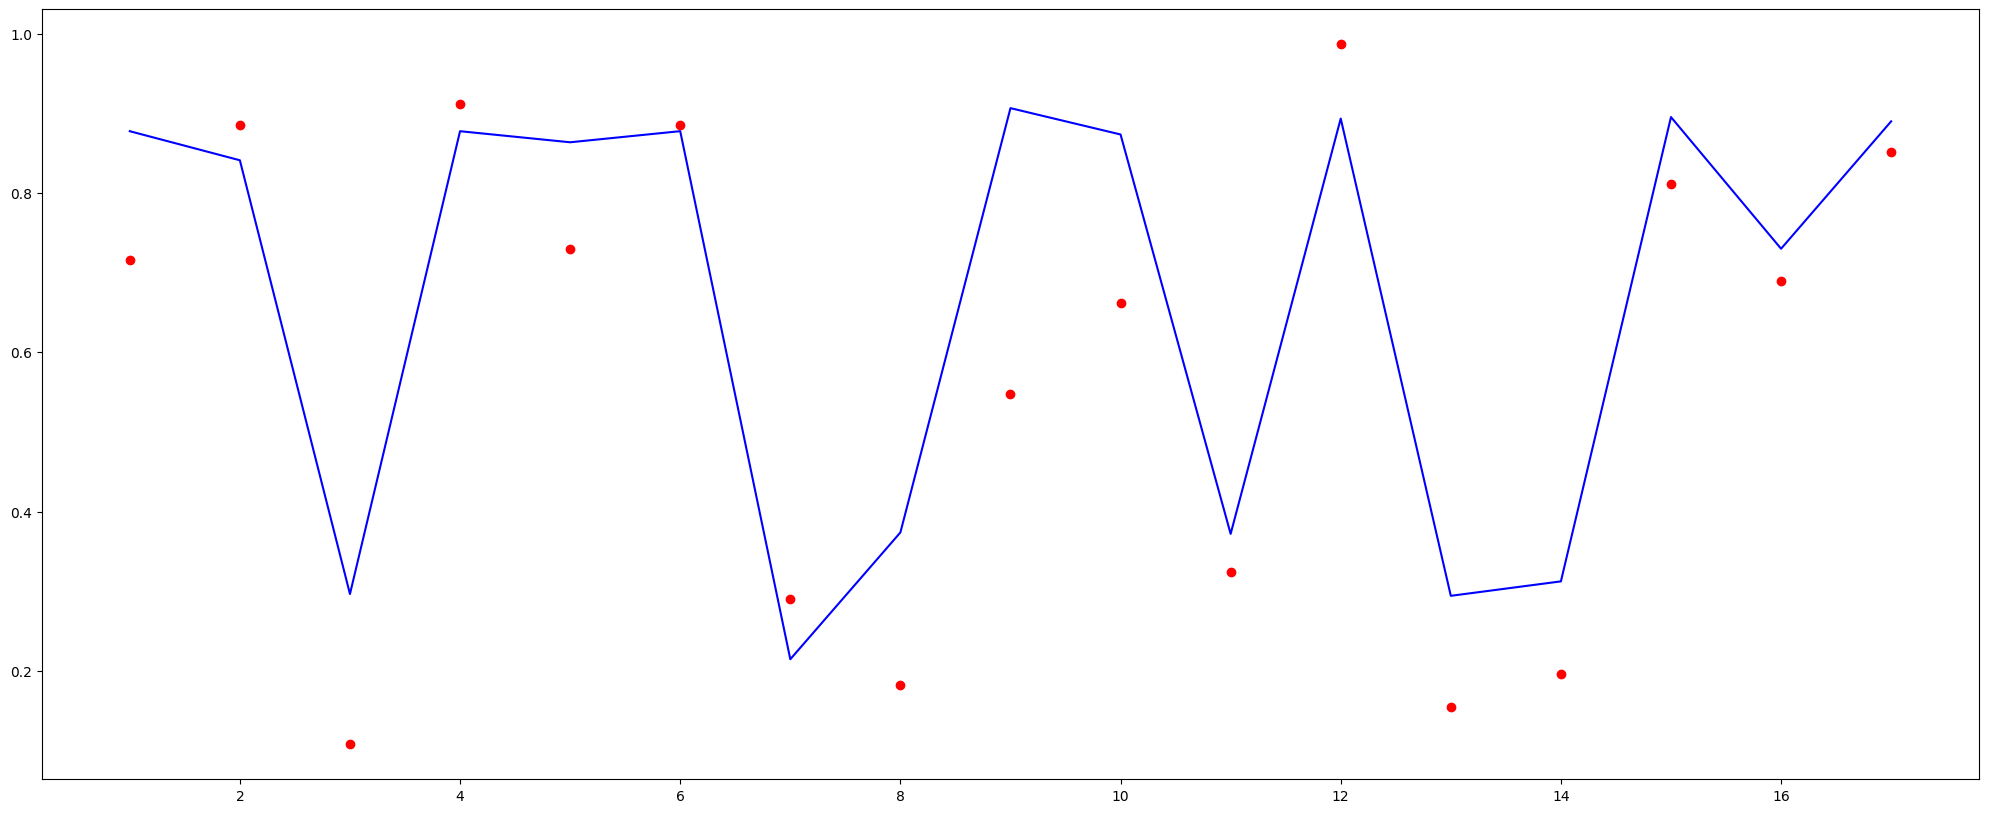

In [20]:

predictedWQI,precitedWQIFixD,red3,gtforRE ,gtforRE2= predictWQI(dataframe,"WQI",(validationset))

0    42.8
1    43.2
2    33.6
3    17.6
4    17.2
dtype: float64
-----For WQI with pH Regression relation-----
[8.4] - [8.2682444]
[8.6] - [8.41144136]
[7.6] - [7.75273536]
[8.4] - [8.43435287]
[8.6] - [8.27970016]
[8.3] - [8.41144136]
[7.9] - [7.90738807]
[7.7] - [7.81574202]
[7.7] - [8.12504744]
[8.5] - [8.22242137]
[7.7] - [7.93602746]
[8.7] - [8.49735953]
[7.6] - [7.7928305]
[7.7] - [7.82719777]
[8.6] - [8.3484347]
[8.4] - [8.24533289]
[8.6] - [8.38280197]
[8.6] - [8.35416258]
[8.1] - [8.37134621]


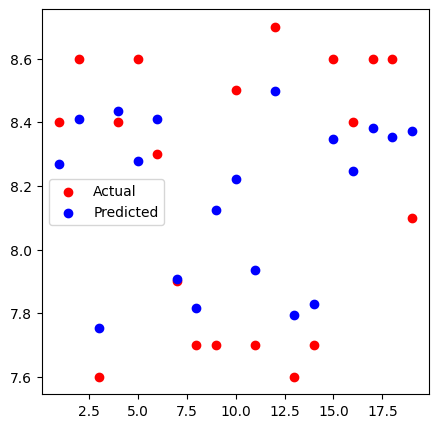

MAE 0.19285316388768226
MSE 0.04643058424742017
RMSE 0.21547757249287028
MAPE 0.02353335196652986
R2 Score 0.7144558617833272
validation results on pH
MAE 0.3247701739274538
MSE 0.11949661489799253
RMSE 0.3456828241292768
MAPE 0.0413263384100287
R2 Score -1.2980118249613972
8.0 - [8.43606184]
8.1 - [8.3386481]
8.1 - [8.41019832]
7.8 - [7.96130461]
7.5 - [7.97763799]
---------------------------------------
-----For WQI with Salinity  Regression relation-----
[35] - [35.43584339]
[38] - [39.08316181]
[24] - [22.30549707]
[40] - [39.66673276]
[33] - [35.72762886]
[40] - [39.08316181]
[25] - [26.24460097]
[25] - [23.91031718]
[35] - [31.78852497]
[32] - [34.26870149]
[30] - [26.97406465]
[40] - [41.27155286]
[25] - [23.32674623]
[25] - [24.20210265]
[35] - [37.4783417]
[34] - [34.85227244]
[37] - [38.35369813]
[36] - [37.62423444]
[40] - [38.06191265]


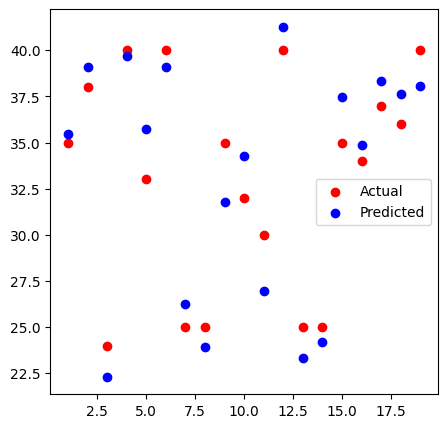

MAE 1.5800513756775196
MSE 3.1646363514276787
RMSE 1.7789424812027168
MAPE 0.04942243128465314
R2 Score 0.9007442464930154
validation results on Salinity
MAE 8.928526913028017
MSE 87.68673046820878
RMSE 9.364119310870018
MAPE 0.3563735290612459
R2 Score -4.269635244483701
30 - [39.71026134]
30 - [37.22907089]
25 - [39.05150081]
20 - [27.61788992]
22 - [28.0339116]
---------------------------------------
-----For WQI with Ammonia SVR relation-----


<ipython-input-13-51c8a6173c99>:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=2, random_state=0).fit(xTrain, yTrain)


[0.] - 0.03533944434770452
[0.] - 0.03655200900054396
[0.05] - 0.05609102129865352
[0.04] - 0.030002383671539942
[0.02] - 0.03533944434770452
[0.05] - 0.03655200900054396
[0.12] - 0.058194796828679035
[0.06] - 0.052402473318855544
[0.1] - 0.0471949507355824
[0.02] - 0.03611769881382664
[0.02] - 0.05951823117211339
[0.] - 0.044260400654741267
[0.07] - 0.05609102129865352
[0.08] - 0.05257913998552221
[0.04] - 0.03776550106403602
[0.01] - 0.035615268523528705
[0.] - 0.03753216773070269
[0.] - 0.03776550106403602
[0.08] - 0.03753216773070269


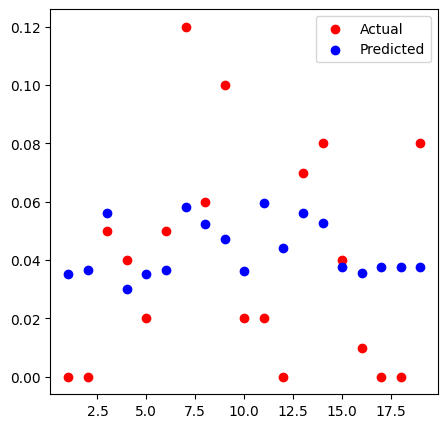

MAE 0.02767456543786526
MSE 0.001043656311226438
RMSE 0.03230566995476859
MAPE 45379578922743.06
R2 Score 0.20042460027006748
validation results on Ammonia
MAE 0.018319059196427945
MSE 0.000502845463706646
RMSE 0.022424216010970062
MAPE 0.32760548277777624
R2 Score -0.33735495666661164
0.07 - 0.030002383671539942
0.03 - 0.03704346643200138
0.04 - 0.03655200900054396
0.04 - 0.05854585021973244
0.08 - 0.05743962799751021
---------------------------------------


In [21]:

wqi,expdf= calculateWQI(validationset[parameters])
## plotting distribution of wqi
print(wqi)
validationset['WQI'] = wqi
validationset['WQI'] = scaler2.fit_transform(validationset[['WQI']]).flatten()
# validationset['WQI'] = scaler2.fit_transform(np.array(wqi).reshape(1, -1))
# plt.hist(wqi)
WQIandParameters(dataframe,'WQI',np.array(red3).reshape(-1, 1),validationset[parameters])

0    0.716216
1    0.918919
2    0.952703
3    0.986486
4    0.817568
Name: WQI, dtype: float64
-----For WQI with pH Regression relation-----
[8.4] - [8.2682444]
[8.6] - [8.41144136]
[7.6] - [7.75273536]
[8.4] - [8.43435287]
[8.6] - [8.27970016]
[8.3] - [8.41144136]
[7.9] - [7.90738807]
[7.7] - [7.81574202]
[7.7] - [8.12504744]
[8.5] - [8.22242137]
[7.7] - [7.93602746]
[8.7] - [8.49735953]
[7.6] - [7.7928305]
[7.7] - [7.82719777]
[8.6] - [8.3484347]
[8.4] - [8.24533289]
[8.6] - [8.38280197]
[8.6] - [8.35416258]
[8.1] - [8.37134621]


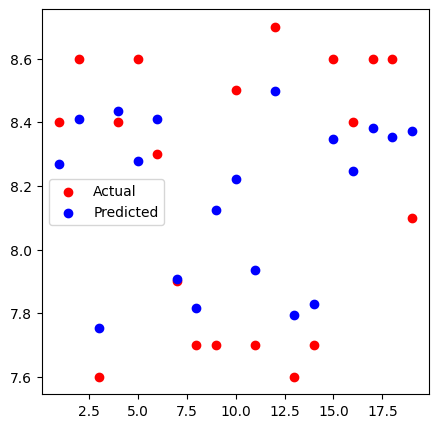

MAE 0.19285316388768226
MSE 0.04643058424742017
RMSE 0.21547757249287028
MAPE 0.02353335196652986
R2 Score 0.7144558617833272
validation results on pH
MAE 0.21192649197357838
MSE 0.07113587679044374
RMSE 0.26671309827311396
MAPE 0.02647807692448612
R2 Score 0.5845135733136975
8.4 - [8.40488841]
8.6 - [8.37397172]
7.6 - [7.91258116]
8.4 - [8.40488477]
8.6 - [8.39311442]
8.3 - [8.40492881]
7.9 - [7.84319102]
7.7 - [7.97805288]
7.7 - [8.42942686]
8.5 - [8.40141144]
7.7 - [7.97653344]
8.7 - [8.41834546]
7.6 - [7.91065663]
7.7 - [7.92602376]
8.6 - [8.4199245]
8.4 - [8.27987074]
8.6 - [8.41539706]
---------------------------------------
-----For WQI with Salinity  Regression relation-----
[35] - [35.43584339]
[38] - [39.08316181]
[24] - [22.30549707]
[40] - [39.66673276]
[33] - [35.72762886]
[40] - [39.08316181]
[25] - [26.24460097]
[25] - [23.91031718]
[35] - [31.78852497]
[32] - [34.26870149]
[30] - [26.97406465]
[40] - [41.27155286]
[25] - [23.32674623]
[25] - [24.20210265]
[35] - [37.478

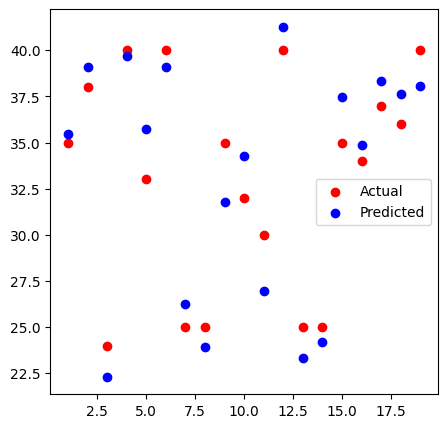

MAE 1.5800513756775196
MSE 3.1646363514276787
RMSE 1.7789424812027168
MAPE 0.04942243128465314
R2 Score 0.9007442464930154
validation results on Salinity
MAE 2.5297796736348874
MSE 9.826657989027623
RMSE 3.1347500680321585
MAPE 0.07993385112211303
R2 Score 0.6930497018126911
35 - [38.916254]
38 - [38.12878607]
24 - [26.37687222]
40 - [38.9161613]
33 - [38.61636292]
40 - [38.91728314]
25 - [24.60946085]
25 - [28.04447897]
35 - [39.54126404]
32 - [38.82769323]
30 - [28.00577796]
40 - [39.25901369]
25 - [26.32785337]
25 - [26.71926389]
35 - [39.299233]
34 - [35.73197367]
37 - [39.18391602]
---------------------------------------
-----For WQI with Ammonia SVR relation-----


<ipython-input-13-51c8a6173c99>:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(max_depth=2, random_state=0).fit(xTrain, yTrain)


[0.] - 0.03533944434770452
[0.] - 0.03655200900054396
[0.05] - 0.05609102129865352
[0.04] - 0.030002383671539942
[0.02] - 0.03533944434770452
[0.05] - 0.03655200900054396
[0.12] - 0.058194796828679035
[0.06] - 0.052402473318855544
[0.1] - 0.0471949507355824
[0.02] - 0.03611769881382664
[0.02] - 0.05951823117211339
[0.] - 0.044260400654741267
[0.07] - 0.05609102129865352
[0.08] - 0.05257913998552221
[0.04] - 0.03776550106403602
[0.01] - 0.035615268523528705
[0.] - 0.03753216773070269
[0.] - 0.03776550106403602
[0.08] - 0.03753216773070269


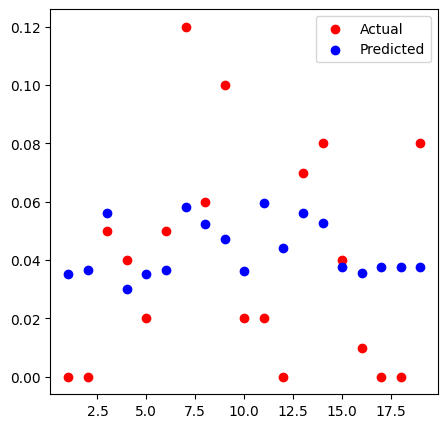

MAE 0.02767456543786526
MSE 0.001043656311226438
RMSE 0.03230566995476859
MAPE 45379578922743.06
R2 Score 0.20042460027006748
validation results on Ammonia
MAE 0.025673856374793306
MSE 0.0010213405906539365
RMSE 0.03195841971459065
MAPE 35937583984560.38
R2 Score 0.19616712772606837
0.0 - 0.036987723286258246
0.0 - 0.03753216773070269
0.05 - 0.058194796828679035
0.04 - 0.036987723286258246
0.02 - 0.036987723286258246
0.05 - 0.036987723286258246
0.12 - 0.05445106306244529
0.06 - 0.05743962799751021
0.1 - 0.030002383671539942
0.02 - 0.036987723286258246
0.02 - 0.05743962799751021
0.0 - 0.03056790091291925
0.07 - 0.058194796828679035
0.08 - 0.05951823117211339
0.04 - 0.03056790091291925
0.01 - 0.03533944434770452
0.0 - 0.03056790091291925
---------------------------------------


In [22]:

# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)

print(dataframe["WQI"].head())

# dataframe['WQI'] = scaler2.inverse_transform(dataframe[['WQI']]).flatten()
# print(dataframe["WQI"].head())
WQIandParameters(dataframe,'WQI',predictedWQI.reshape(-1, 1),gtforRE)
# WQIandParameters(dataframe,'WQI',precitedWQIFixD.reshape(-1, 1),gtforRE2)

Mean WQI 0.6699365732392693
Standard Deviation WQI 0.2780777105098268


(array([ 1.,  3.,  2.,  0.,  0.,  0.,  0.,  1.,  0., 10.]),
 array([0.214812  , 0.28396593, 0.35311986, 0.42227379, 0.49142772,
        0.56058165, 0.62973558, 0.69888951, 0.76804345, 0.83719738,
        0.90635131]),
 <BarContainer object of 10 artists>)

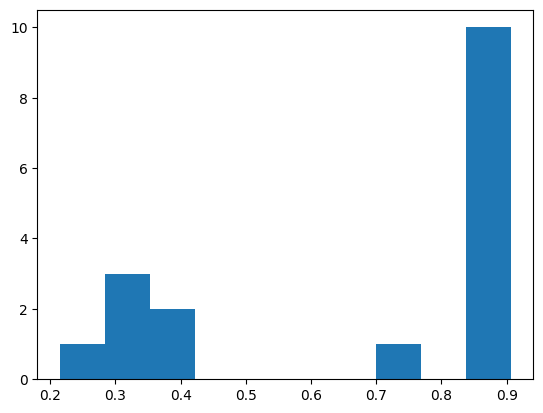

In [23]:
#
## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(predictedWQI))
print("Standard Deviation WQI", statistics.stdev(predictedWQI))
plt.hist(predictedWQI)

In [24]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RepeatedKFold
from numpy import absolute,mean,std
from sklearn.linear_model import Ridge,HuberRegressor

In [25]:
# model = LinearSVR()
# model = Ridge(alpha = .002,random_state=123)
model = HuberRegressor(max_iter = 1000)
# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(model)

In [26]:
X = np.array(dataframe['WQI']).reshape(-1, 1)
y = dataframe[parameters]


In [27]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 0.635 (0.184)


In [28]:
validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]
xTrain = np.array(traindataframe['WQI']).reshape(-1, 1)
yTrain = traindataframe[parameters]
xTest =  np.array(validationdataframe['WQI']).reshape(-1, 1)
yTest = validationdataframe[parameters]

# xTrain, xTest, yTrain, yTest = train_test_split(np.array(dataframe['WQI']).reshape(-1, 1), dataframe[parameters], test_size=0.33, random_state=42)

In [29]:
regr = wrapper.fit(xTrain, yTrain)
prediction = regr.predict(xTest)
Presults(yTest, prediction)

MAE 0.971611303277836
MSE 2.8380060817887904
RMSE 1.1068310376464383
MAPE 0.2632482238024373
R2 Score -1.994446509667089


In [30]:
for index, col in enumerate(yTest.columns):
  yTest[f'{col}_pred'] = prediction[:,index]

<ipython-input-30-ed4dba7d913f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yTest[f'{col}_pred'] = prediction[:,index]
<ipython-input-30-ed4dba7d913f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yTest[f'{col}_pred'] = prediction[:,index]
<ipython-input-30-ed4dba7d913f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [31]:
yTest

,pH,Salinity,Ammonia,pH_pred,Salinity_pred,Ammonia_pred
51,8.0,35,0.04,8.260028,32.558056,0.031651
52,8.5,40,0.08,8.716535,39.526371,0.007669
53,8.1,40,0.08,8.547458,36.945514,0.016551
54,8.2,40,0.05,8.564366,37.203600,0.015663
55,7.9,36,0.08,8.293843,33.074228,0.029875
56,7.7,35,0.10,8.183943,31.396670,0.035648
57,8.5,40,0.12,8.750351,40.042543,0.005892
58,8.2,40,0.04,8.555912,37.074557,0.016107
59,8.4,42,0.05,8.733443,39.784457,0.006780
60,8.0,40,0.07,8.496735,36.171257,0.019216


In [32]:
Presults(yTest['pH'], yTest['pH_pred']),Presults(yTest['Salinity'], yTest['Salinity_pred']),Presults(yTest['Ammonia'], yTest['Ammonia_pred'])

MAE 0.35543019780500856
MSE 0.14078322300496485
RMSE 0.3752109046988971
MAPE 0.04398042552619241
R2 Score -0.9674674022432983
MAE 2.5139537689444214
MSE 8.370520930009217
RMSE 2.8931852567730982
MAPE 0.06497866065510685
R2 Score -1.1305058928190879
MAE 0.04544994308407813
MSE 0.0027140923521882664
RMSE 0.05209695146731972
MAPE 0.6807855852260126
R2 Score -3.885366233938881


(None, None, None)

In [33]:
unkval = predictedWQI.reshape(-1, 1)
kval = gtforRE.copy()
prediction = regr.predict(unkval)
Presults(gtforRE, prediction)

MAE 0.8499724341015037
MSE 2.4172249120229883
RMSE 0.9986486899276753
MAPE 4975163573463.439
R2 Score 0.4960116408030169


In [34]:
for index, col in enumerate(kval.columns):
  kval[f'{col}_pred'] = prediction[:,index]

In [35]:
kval

,pH,Salinity,Ammonia,pH_pred,Salinity_pred,Ammonia_pred
0,8.4,35,0.00,8.596964,37.701183,0.013950
5,8.6,38,0.00,8.551333,37.004664,0.016347
45,7.6,24,0.05,7.870361,26.610036,0.052122
13,8.4,40,0.04,8.596958,37.701101,0.013951
19,8.6,33,0.02,8.579586,37.435928,0.014863
62,8.3,40,0.05,8.597023,37.702093,0.013947
48,7.9,25,0.12,7.767948,25.046752,0.057502
37,7.7,25,0.06,7.966992,28.085043,0.047046
56,7.7,35,0.10,8.633180,38.254008,0.012048
12,8.5,32,0.02,8.591832,37.622851,0.014220


In [36]:
Presults(kval['pH'], kval['pH_pred']),Presults(kval['Salinity'], kval['Salinity_pred']),Presults(kval['Ammonia'], kval['Ammonia_pred'])

MAE 0.19436283766941637
MSE 0.08206491986835128
RMSE 0.28646975384558715
MAPE 0.024628143871603135
R2 Score 0.5206798334285867
MAE 2.3314628491982656
MSE 7.168582261550603
RMSE 2.677420822648282
MAPE 0.07339363664379818
R2 Score 0.7760786561188798
MAE 0.024091615436828834
MSE 0.0010275546500111638
RMSE 0.0320554932891566
MAPE 14925490720390.22
R2 Score 0.19127643286158402


(None, None, None)

In [37]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import fsolve

In [38]:
validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]
X_new = np.array(traindataframe['WQI']).reshape(-1, 1)
y_new = np.asarray(traindataframe[parameters])

X_new_val = np.array(validationdataframe['WQI']).reshape(-1, 1)
y_new_val = np.asarray(validationdataframe[parameters])


In [39]:
# y_new = np.array(dataframe['WQI'],dtype=np.float64).reshape(-1, 1).ravel()
# X_new = np.asarray(dataframe['pH']).reshape(-1, 1)

In [40]:
X_new.shape

(41, 1)

In [41]:
y_new.shape

(41, 3)

In [42]:
pf = PolynomialFeatures(degree = 4).fit(X_new)
X_poly = pf.transform(X_new).astype(float)
X_poly[0]
regression_model = LinearRegression()

regression_model.fit(X_poly, y_new)

y_pred = regression_model.predict(X_poly)
print(regression_model.coef_)

mean_squared_error(y_new, y_pred, squared=False)

[[  0.          -0.28155634  11.43904381 -20.14468049  10.22068342]
 [  0.          22.92691108 -75.24333805 150.31158332 -80.13685595]
 [  0.           0.47443262  -1.95735501   2.55676108  -1.10349891]]


0.5827771802500589

In [43]:
Y_val_pred = regression_model.predict(pf.transform(X_new_val).astype(float))

MAE 0.11823699540780773
MSE 0.024812783580793547
RMSE 0.15752074016075962
MAPE 0.014394250598289086
R2 Score 0.8327976862049469
MAE 0.34734460920715066
MSE 0.1539570704613658
RMSE 0.3923736362975548
MAPE 0.04329089308013987
R2 Score -1.1515739660749893


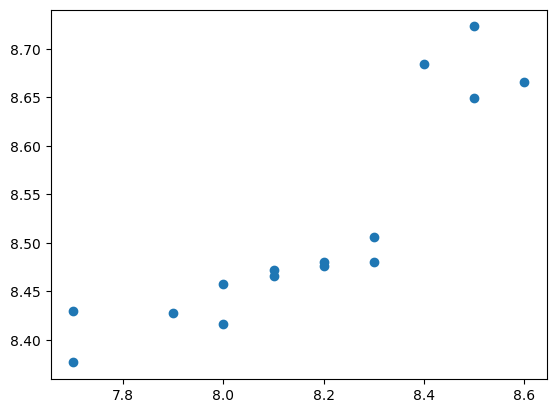

In [44]:
Presults(y_new[:,0],y_pred[:,0])
Presults(y_new_val[:,0],Y_val_pred[:,0])
plt.figure()
plt.scatter(y_new_val[:,0],Y_val_pred[:,0])
plt.show()

In [45]:
# from scipy.optimize import fsolve
# sub_X_poly = X_poly[:3]
# sub_y_new = y_new[:3]
# def f(w):
#     f = np.zeros(len(sub_X_poly))
#     for i in range(len(f)):
#         f[i] = X_poly[i,0] +X_poly[i,1]*w[0] +X_poly[i,2] *w[1]+\
#              X_poly[i,3]*w[2] + X_poly[i,4] *(w[0]**2) +X_poly[i,5]*(w[1]**2) +\
#              X_poly[i,6]*(w[2]**2) +X_poly[i,7]*(w[0]*w[1]) +X_poly[i,8]*(w[1]*w[2])+\
#              X_poly[i,9]*(w[0]*w[2]) - sub_y_new[i]
#       # f[i] = X_poly[i,0] +X_poly[i,1]*w[0] +X_poly[i,2] *w[1]+\
#       #        X_poly[i,3]*w[2] + X_poly[i,4] *(w[0]**2) +X_poly[i,5]*(w[1]**2) +\
#       #        X_poly[i,6]*(w[2]**2) +X_poly[i,7]*(w[0]*w[1]) +X_poly[i,8]*(w[1]*w[2])+\
#       #        X_poly[i,9]*(w[0]*w[2]) - sub_y_new[i]
#     return f
# # z = fsolve(f,[1,1]); print(z)
# # z = fsolve(f,[-2,-2]); print(z)
# # generate an initial guess
# initialGuess=[0,0,0]

# # solve the problem
# solutionInfo=fsolve(f,initialGuess,full_output=1)


# HQWI Index


In [46]:
allWQI = harmonizedWQIcalculation(dataframe[parameters])
dataframe['HWQI'] = allWQI
scaler3 = MinMaxScaler()
dataframe['HWQI'] = scaler3.fit_transform(dataframe[['HWQI']]).flatten()

(array([ 4.,  3.,  1., 20.,  5., 15.,  3.,  3.,  0.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

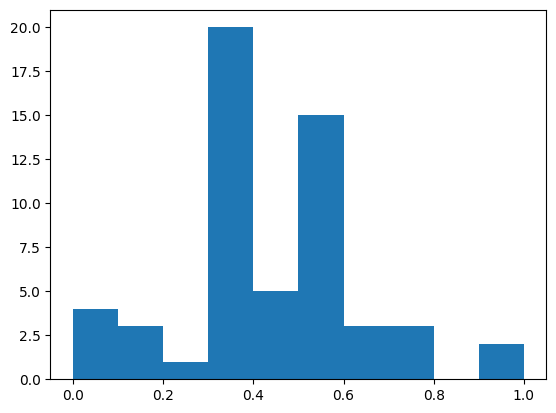

In [47]:
plt.hist(dataframe['HWQI'])

In [48]:
(dataframe).corrwith(dataframe['HWQI'])

<ipython-input-48-0036a586283d>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['HWQI'])


pH             0.106968
Salinity       0.559821
Carbonate     -0.014115
BiCarbonate   -0.051408
Alkalinity    -0.010036
Hardness       0.433366
Calcium       -0.268119
Magnesium      0.457176
Ammonia        0.585113
Coincidence         NaN
B1            -0.494090
B10           -0.388352
B11           -0.323860
B12           -0.368513
B2            -0.551185
B3            -0.596716
B4            -0.556939
B5            -0.448563
B6            -0.405611
B7            -0.383047
B8            -0.440615
B8A           -0.398462
B9            -0.454930
WQI            0.498885
HWQI           1.000000
dtype: float64

In [49]:
# predictedWQI,gtforRE = predictWQI(dataframe,"HWQI")
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)
# WQIandParameters(dataframe,'HWQI',predictedWQI.reshape(-1, 1),gtforRE)
# WQIandParameters(dataframe,'HWQI',predictedWQI.reshape(-1, 1),gtforRE,scaler3)
# WQIandParameters(np.array(dataframe['HWQI']).reshape(-1, 1),dataframe[parameters],predictedWQI.reshape(-1, 1),gtforRE)

In [50]:
## Not good code

In [51]:


# #to train model to predict the WQI using band  indcies using ML
# def WQIandBands(df1,WQI):
#   print('-----For WQI prediction with Bands with SVR algo -----')
#   X_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['pH']]
#   X_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['pH']]
#   # X_train, X_test, y_train, y_test = train_test_split(Bandsndices, WQI, test_size=0.33, random_state=42)
#   model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
#   model.fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   return prediction


# def CM(actual, predicted):
#   fig = plt.figure()
#   plt.scatter(actual, predicted)
#   plt.show()

# def LRegression(WQI,GT):
#   X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
#   model = LinearRegression().fit(X_train, y_train)
#   # model1 = SVR(kernel='rbf', C=1.0, epsilon=0.2).fit(X_train, y_train)
#   # model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   for x,y in zip(y_test.values,prediction):
#     print(x,'-',y)

#   CM(WQI,GT)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   # return model.coef_,model.intercept_
# #to predict the parameters from WQI



# def WQIandParameters(WQI,GT):
#   print('-----For WQI with pH Regression relation-----')
#   LRegression(WQI,GT['pH'])
#   print('-----For WQI with Salinity  Regression relation-----')
#   LRegression(WQI,GT['Salinity'])
#   print('-----For WQI with Ammonia SVR relation-----')
#   LRegression(WQI,GT['Ammonia'])
#   return None



## WQI with only bands

In [52]:
# WQI = WQIcalculation(df1 ,GT1)
# # len(WQI)
# WQIandBands(df1,WQI)
# WQIandParameters(np.array(WQI).reshape(-1, 1),GT)

## WQI with  top  10 combination indices

In [53]:
#   corrwithWQI = newdf.corrwith(newdf['WQI_cal'])
# type(corrwithWQI)
# corrdict  = corrwithWQI.to_dict()
# sortedkeys = sorted(corrdict, key=corrdict.get, reverse=True)
# for r in sortedkeys[:11]:
#     print(r, corrdict[r])

In [54]:
# newtraindf = newdf[sortedkeys].drop('WQI_cal',axis = 1)
# scaler = StandardScaler()
# scaler.fit(newtraindf)
# newscaledtraindf = scaler.transform(newtraindf)
# WQIandBands(newscaledtraindf,WQI)

In [55]:
# plt.scatter(df['norm_NarrowNIR_SWIR1'],df['WQI_cal'])
# plt.scatter(df['norm_NarrowNIR_SWIR2'],df['WQI_cal'])
# plt.scatter(df['norm_WaterVapour_SWIR2'],df['WQI_cal'])

## WQI with  PCA 3 bands